In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
from scipy.stats import sem

import statistics
from os.path import exists
import pickle

game_titles = {
        "shuffleKeys_game": "Shuffle Keys Game",
        "contingency_game": "Contingency Game",
        "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
        "contingency_game_shuffled_200": "Switching Mappings Game \n(Shuffled Every 200 Levels)",
        "contingency_game_shuffled_100": "Switching Mappings Game \n(Shuffled Every 100 Levels)",
        "contingency_game_shuffled_1": "Switching Mappings Game \n(Shuffled Every Level)",
        "logic_game": "Logic Game",
        "logic_extended_game": "Ext Logic",
        "change_agent_game": "Switching Embodiments Game"
}

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

def get_seed_num_and_iter(x):
    if "seed" in x:
        return int(find_between(x.split("/")[4], "seed", "-")) * 1000000000 + int(x.split("/")[-1][6:-5])
    else:
        return int(x.split("/")[4].split("iter")[1]) * 1000000000 + int(x.split("/")[-1][6:-5])



In [2]:
def plot_all_interactions(game_types, agent_types, only_first_100=False, only_last_100=False, show_proportion=False):
    for game in game_types:
        plot_interaction(game, agent_types, only_first_100, only_last_100, show_proportion)

def plot_interaction(game_type, agent_types, only_first_100, only_last_100, show_proportion):
    stats = {}

    fpath = './plotting_data/bar_' + game_type + "_agents=" + ','.join(agent_types) + '_{}{}'.format(only_first_100, only_last_100) + ".pickle"
    if exists(fpath):
        stats = pickle.load(open(fpath, 'rb'))
    else:
        for agent in agent_types:
            w, ns, w_sem, ns_sem = get_interaction_counts(game_type, agent, only_first_100, only_last_100)
            stats[agent] = [w, ns, w_sem, ns_sem] # Wall Interaction Count, Non-Self (NS) Interaction Count, Wall SEM, NS SEM

        # Save data
        with open(fpath, 'wb') as f:
            pickle.dump(stats, f)



    # Normalize the counts
    if show_proportion:
        normalize(stats)

    sorted_stats = {k: v for k, v in sorted(stats.items(), key=lambda item: item[1][0])}


    label_dict = { 'human': 'Human', 'self_class': 'Self Class', 'a2c_training': "A2C",
                    'trpo_training': 'TRPO', 'acer_training': 'ACER',
                       'ppo2_training':'PPO2', 'random': 'Random', 'dqn_training': 'DQN', 'option_critic': 'OC', 'keep_close': 'Proximity'}

    labels = [label_dict[n] for n in list(sorted_stats.keys())]
    x = np.arange(len(agent_types))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    plt.xticks(rotation=45)

    all_w = [i[1][0] for i in sorted_stats.items()]
    all_w_sem = [i[1][2] for i in sorted_stats.items()]

    all_ns = [i[1][1] for i in sorted_stats.items()]
    all_ns_sem = [i[1][3] for i in sorted_stats.items()]

    wall = ax.bar(x - width/2, all_w, width,  capsize=3, label='Wall', color="#00fa9a", yerr=all_w_sem)
    non_self = ax.bar(x + width/2, all_ns, width, capsize=3, label='Non-self', color="#e500fa", yerr=all_ns_sem)

    y_str = 'Average Interaction Count\n{}'.format('For The First Hundred Levels' if only_first_100 else '')

    if only_last_100:
        y_str = 'Average Interaction Count\n{}'.format('For The Last Hundred Levels')

    if show_proportion and not only_last_100 and not only_first_100:
        y_str = 'Proportion of Wall and Non-Self\n Interactions For All Levels'

    ax.set_ylabel(y_str, fontsize=10)
    #ax.set_title( game_titles[game_type], fontweight='bold', fontsize=15 )
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10)
    #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    plt.tight_layout()

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    path = './plots/{}/{}/'.format(game_type, 'bars')
    if not os.path.exists(path):
        os.makedirs(path)

    fname = path + game_type + "_interactions{}{}{}.pdf".format(only_first_100, only_last_100, show_proportion)
    fig.savefig(fname, format='pdf')

    plt.show()

def get_interaction_counts(game_type, agent_type, only_first_100, only_last_100):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json") + glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    # Skip stress test files
    if agent_type not in ["human", "self_class", "random"]:
        files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]

    seed = 0
    curr_file_count = 0
    file_amt = len(files)
    all_seeds_w = []
    all_seeds_ns = []
    w_count, ns_count = [0, 0]
    sorted_files = sorted(files, key=os.path.getmtime if agent_type == 'human' else get_seed_num_and_iter)
    for i, file in enumerate(sorted_files):
        data = json.load(open(file))
        print("Getting... ", file)
        data = data.get("data")

        wall_interactions = data["wall_interactions"]
        ns_interactions = data["ns_interactions"]

        w_count += sum(wall_interactions) / len(wall_interactions)
        ns_count += sum(ns_interactions) / len(wall_interactions)

        curr_file_count += 1
        # All levels
        if agent_type != 'human' and curr_file_count == 20 and not only_first_100 and not only_last_100:
            print(file)
            all_seeds_w.append(w_count / curr_file_count)
            all_seeds_ns.append(ns_count / curr_file_count)
            curr_file_count = 0
            w_count = 0
            ns_count = 0
            seed += 1

        # Only first 100 for all seeds
        if agent_type != 'human' and ((curr_file_count - 1) % 20 == 0) and only_first_100 and not only_last_100:
            print(file)
            all_seeds_w.append(sum(wall_interactions) / len(wall_interactions))
            all_seeds_ns.append(sum(ns_interactions) / len(wall_interactions))
            seed += 1
            w_count = 0
            ns_count = 0
            seed += 1

        # Only last 100 for all seeds
        if agent_type != 'human' and (curr_file_count % 20 == 0) and not only_first_100 and only_last_100:
            print(file)
            all_seeds_w.append(sum(wall_interactions) / len(wall_interactions))
            all_seeds_ns.append(sum(ns_interactions) / len(wall_interactions))
            seed += 1
            w_count = 0
            ns_count = 0
            seed += 1


        if agent_type == 'human':
            print(file)
            all_seeds_w.append(w_count)
            all_seeds_ns.append(ns_count)

            w_count = 0
            ns_count = 0

            if (curr_file_count == file_amt) or (file_amt == 1):
                break

    seed_sem_w = sem(all_seeds_w, axis=0)
    seed_sem_ns = sem(all_seeds_ns, axis=0)

    seed_avg_w = statistics.mean(all_seeds_w)
    seed_avg_ns = statistics.mean(all_seeds_ns)

    return seed_avg_w, seed_avg_ns, seed_sem_w, seed_sem_ns

# Normalize wall and non-self counts along with the sem's
def normalize(stats):
    for key, item in stats.items():
        w_c = item[0]
        ns_c = item[1]
        w_sem_c = item[2]
        ns_sem_c = item[3]
        sum_c = w_c + ns_c
        if sum_c == 0:
            continue

        stats[key][0] = w_c / sum_c
        stats[key][1] = ns_c / sum_c
        stats[key][2] = w_sem_c / sum_c
        stats[key][3] = ns_sem_c / sum_c

In [3]:
agent_types = ["human", "self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", "random", "option_critic", "keep_close"]
game_types = ["change_agent_game"] #["logic_game", "contingency_game", "contingency_game_shuffled_1",] # "change_agent_game", "contingency_game_shuffled_100", "contingency_game_shuffled_200"

for game in game_types:
    # Plot interaction frequencies for each game and agent.
    # Show counts of first hundred only:
    plot_all_interactions([game], agent_types, only_first_100=True, only_last_100=False, show_proportion=False)

    # Show counts of last hundred only:
    plot_all_interactions([game], agent_types, only_first_100=False, only_last_100=True, show_proportion=False)

    # Show proportion of w to ns interaction in all levels:
    plot_all_interactions([game], agent_types, only_first_100=False, only_last_100=False, show_proportion=True)

Getting...  ../data/change_agent_game/human/4_2021-12-17=17:31:11.json
../data/change_agent_game/human/4_2021-12-17=17:31:11.json
Getting...  ../data/change_agent_game/human/15_2021-12-17=17:42:12.json
../data/change_agent_game/human/15_2021-12-17=17:42:12.json
Getting...  ../data/change_agent_game/human/10_2021-12-17=22:14:58.json
../data/change_agent_game/human/10_2021-12-17=22:14:58.json
Getting...  ../data/change_agent_game/human/9_2021-12-17=22:16:08.json
../data/change_agent_game/human/9_2021-12-17=22:16:08.json
Getting...  ../data/change_agent_game/human/12_2021-12-17=22:23:17.json
../data/change_agent_game/human/12_2021-12-17=22:23:17.json
Getting...  ../data/change_agent_game/human/2_2021-12-17=22:27:25.json
../data/change_agent_game/human/2_2021-12-17=22:27:25.json
Getting...  ../data/change_agent_game/human/14_2021-12-17=22:28:07.json
../data/change_agent_game/human/14_2021-12-17=22:28:07.json
Getting...  ../data/change_agent_game/human/13_2021-12-17=22:28:21.json
../data/ch

In [ ]:
# Plot bar chart for total step amounts.

def plot_all_total_steps(game_types, agent_types, only_first_100=False, only_last_100=False):
    for game in game_types:
        plot_total_steps(game, agent_types, only_first_100, only_last_100)

def plot_total_steps(game_type, agent_types, only_first_100, only_last_100):
    total_mean_sem = {}

    fpath = './plotting_data/bar_total_' + game_type + "_agents=" + ','.join(agent_types) + '{}{}'.format(only_first_100, only_last_100) + ".pickle"
    if exists(fpath):
        total_mean_sem = pickle.load(open(fpath, 'rb'))
    else:
        for agent in agent_types:
            mean, sem = get_mean_and_sem(game_type, agent, only_first_100, only_last_100)
            total_mean_sem[agent] = (mean, sem)

        # Save data
        with open(fpath, 'wb') as f:
            pickle.dump(total_mean_sem, f)


    total_mean_sem = {k: v for k, v in sorted(total_mean_sem.items(), key=lambda item: item[1][0])}

    label_dict = { 'human': 'Human', 'self_class': 'Self Class', 'a2c_training': "A2C", 'trpo_training': 'TRPO',
                   'acer_training': 'ACER', 'ppo2_training':'PPO2', 'dqn_training': 'DQN',
                   'random': 'Random', 'option_critic': 'OC', 'keep_close': 'Proximity'}

    fig, ax = plt.subplots()
    colors = {"human": "#000000", "self_class": "#19c202", "random": "#9c2200", "a2c_training": "#89CFF0",
          "trpo_training": "#0000FF",
          "acer_training": "#7393B3", "ppo2_training": "#0096FF", "dqn_training": "#5D3FD3", "option_critic": "#23dedb", "keep_close": "#0f7801"}

    if not only_first_100 and not only_last_100:
        colors.pop('human')
        label_dict.pop('human')

    labels = [label_dict[n] for n in list(total_mean_sem.keys())]
    colors = [colors[n] for n in list(total_mean_sem.keys())]
    x = np.arange(len(labels))
    width = 0.2  # the width of the bars

    all_mean = [i[1][0] for i in total_mean_sem.items()]
    all_sem = [i[1][1] for i in total_mean_sem.items()]

    ts = ax.bar(x, all_mean, width=width, color=colors, yerr=all_sem,
                ecolor='black', capsize=5, alpha=0.5)

    plt.xticks(rotation=45)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    game_titles = {
        "shuffleKeys_game": "Shuffle Keys Game",
        "contingency_game": "Contingency Game",
        "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
        "contingency_game_shuffled_200": "Switching Mappings Game \n(Shuffled Every Two Hundred Levels)",
        "contingency_game_shuffled_100": "Switching Mappings Game \n(Shuffled Every Hundred Levels)",
        "contingency_game_shuffled_1": "Switching Mappings Game \n(Shuffled Every Level)",
        "logic_game": "Logic Game",
        "logic_extended_game": "Ext Logic",
        "change_agent_game": "Switching Embodiments Game"
    }
    lbl = 'Total Steps'
    if only_first_100 and not only_last_100:
        lbl = 'Total Steps\nFor The First Hundred Levels'
    elif only_last_100:
        lbl = 'Total Steps\nFor The Last Hundred Levels'

    ax.set_ylabel(lbl)
    #ax.xaxis.set_label_position('top')
    #ax.set_title( game_titles[game_type], fontweight='bold', fontsize=15 )
    #ax.set_xlabel(game_titles[game_type], fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    #autolabel(ts)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
    plt.tight_layout()

    path = './plots/{}/{}/'.format(game_type, 'bars')
    if not os.path.exists(path):
        os.makedirs(path)

    fname = path + game_type + "_total_steps{}{}.pdf".format(only_first_100, only_last_100)
    fig.savefig(fname, format='pdf')

def get_mean_and_sem(game_type, agent_type, only_first_100, only_last_100):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    # Skip stress test files
    if agent_type not in ["human", "self_class", "random"]:
        files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]


    if len(files) == 0:
        return 0, 0
    seed_count = 0
    all_counts = []
    curr_file_count = 0

    sorted_files = sorted(files, key=os.path.getmtime if agent_type == 'human' else get_seed_num_and_iter)
    for i, file in enumerate(sorted_files):
        print("Getting... ", file)
        data = json.load(open(file))
        data = data.get("data")
        seed_count += sum(data["steps"])

        curr_file_count += 1
        if curr_file_count == 20 and not only_first_100 and not only_last_100:
            all_counts.append(seed_count)
            seed_count = 0
            curr_file_count = 0

        if only_first_100 and ((curr_file_count - 1) % 20 == 0) and agent_type != 'human' and not only_last_100:
            data = json.load(open(file))
            data = data.get("data")
            print(file)
            all_counts.append(sum(data["steps"]))
            seed_count = 0

        if not only_first_100 and (curr_file_count % 20 == 0) and agent_type != 'human' and only_last_100:
            data = json.load(open(file))
            data = data.get("data")
            print(file)
            all_counts.append(sum(data["steps"]))
            seed_count = 0

        if (only_first_100 or only_last_100) and agent_type == 'human':
            print(file)
            all_counts.append(sum(data["steps"]))
            seed_count = 0


    seed_sem = sem(all_counts) 
    seed_avg = statistics.mean(all_counts)

    return seed_avg, seed_sem

Getting...  ../data/logic_game/self_class/iter0/train_0.json
Getting...  ../data/logic_game/self_class/iter0/train_100.json
Getting...  ../data/logic_game/self_class/iter0/train_200.json
Getting...  ../data/logic_game/self_class/iter0/train_300.json
Getting...  ../data/logic_game/self_class/iter0/train_400.json
Getting...  ../data/logic_game/self_class/iter0/train_500.json
Getting...  ../data/logic_game/self_class/iter0/train_600.json
Getting...  ../data/logic_game/self_class/iter0/train_700.json
Getting...  ../data/logic_game/self_class/iter0/train_800.json
Getting...  ../data/logic_game/self_class/iter0/train_900.json
Getting...  ../data/logic_game/self_class/iter0/train_1000.json
Getting...  ../data/logic_game/self_class/iter0/train_1100.json
Getting...  ../data/logic_game/self_class/iter0/train_1200.json
Getting...  ../data/logic_game/self_class/iter0/train_1300.json
Getting...  ../data/logic_game/self_class/iter0/train_1400.json
Getting...  ../data/logic_game/self_class/iter0/trai

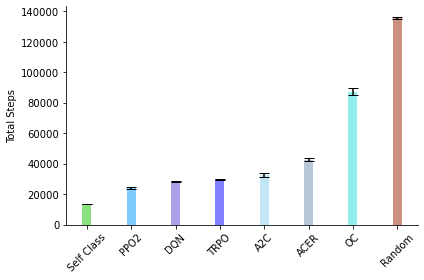

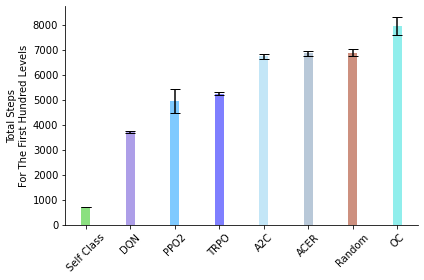

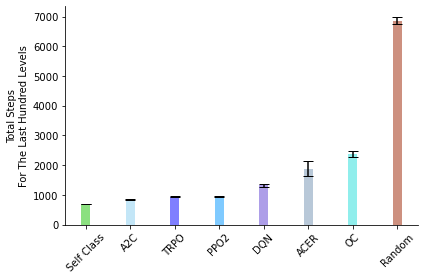

In [9]:
#"human",
agent_types = ["self_class", "random", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", "option_critic", "keep_close"]
game_types = ["change_agent_game"] #["logic_game", "contingency_game","contingency_game_shuffled_1"] #

for game in game_types:
    # Plot interaction frequencies for each game and agent.
    plot_all_total_steps([game], agent_types) #, only_first_100=True
    plot_all_total_steps([game], agent_types, only_first_100=True) #, only_first_100=True
    plot_all_total_steps([game], agent_types, only_first_100=False, only_last_100=True)